<a href="https://colab.research.google.com/github/Saduf2019/test_errors/blob/master/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules
https://github.com/SauravMaheshkar/Named-Entity-Recognition-/blob/master/Named_Entity_Recognition.ipynb


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt # For Plotting
import pandas as pd # For Data Processing/IO
import numpy as np # For Linear Algebra
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf # For building the LSTM Model
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Retrieve Sentences

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

### Making Maps Between Sentences and Tags

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Padding Sentences and creating Train/Test sets


In [ ]:
len(sentences)

47959

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

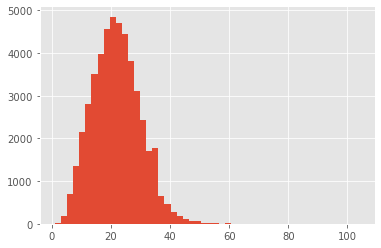

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show() # number of words in a sentence

In [ ]:
len(sentences) # tokens, with POS, and entity in a list

47959

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
sentences[-1]

[('The', 'DT', 'O'),
 ('United', 'NNP', 'B-org'),
 ('Nations', 'NNP', 'I-org'),
 ('is', 'VBZ', 'O'),
 ('praising', 'VBG', 'O'),
 ('the', 'DT', 'O'),
 ('use', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('military', 'JJ', 'O'),
 ('helicopters', 'NNS', 'O'),
 ('to', 'TO', 'O'),
 ('drop', 'VB', 'O'),
 ('food', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('rescue', 'NN', 'O'),
 ('survivors', 'NNS', 'O'),
 ('in', 'IN', 'O'),
 ('tsunami-ravaged', 'JJ', 'B-tim'),
 ('Indonesia', 'NNP', 'I-tim'),
 (',', ',', 'O'),
 ('saying', 'VBG', 'O'),
 ('the', 'DT', 'O'),
 ('aircraft', 'NN', 'O'),
 ('are', 'VBP', 'O'),
 ('"', '``', 'O'),
 ('worth', 'IN', 'O'),
 ('their', 'PRP$', 'O'),
 ('weight', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('gold', 'NN', 'O'),
 ('.', '.', 'O'),
 ('"', '``', 'O')]

In [ ]:
sentences[0][0]

('Thousands', 'NNS', 'O')

In [ ]:
sentences[0][0][0]

'Thousands'

In [ ]:
sentences # sentences include POS

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
len(x_train),len(x_test) #Spliting the sentences but those have been padded now to equal length

(33571, 14388)

In [ ]:
x_train[0]

array([  547,  2346, 30730, 32093, 31890,  9642, 34760, 26103, 11163,
        9642, 21478,  3368,  6329, 12689, 30437,  4119, 31721, 21594,
       24610, 25525, 33565,  6329, 10251, 26665, 20570, 23003,  6264,
       19300,  7253, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178])

In [ ]:
y_train[0]

array([ 7,  7,  7,  7, 14,  7,  7, 14, 15,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7])

### Building and Compiling the Bidirectional LSTM Model

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
#              metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],
              metrics=['accuracy'])

### Training the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

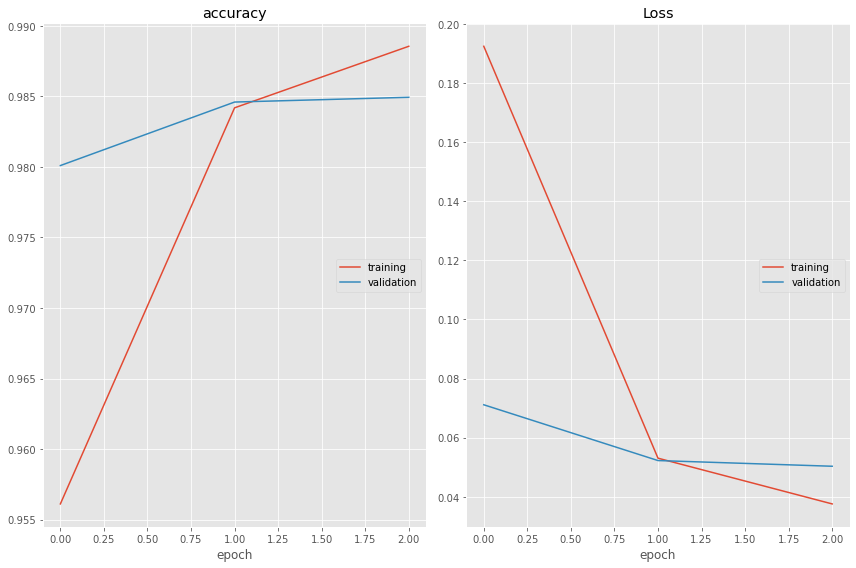

accuracy
	training         	 (min:    0.956, max:    0.989, cur:    0.989)
	validation       	 (min:    0.980, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.038, max:    0.192, cur:    0.038)
	validation       	 (min:    0.050, max:    0.071, cur:    0.050)

Epoch 00003: val_loss improved from 0.05225 to 0.05032, saving model to model_weights.h5
1050/1050 [==============================] - 180s 171ms/step - loss: 0.0376 - accuracy: 0.9886 - val_loss: 0.0503 - val_accuracy: 0.9849
Wall time: 9min 19s


In [ ]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Evaluating the NER Model

In [ ]:
x_test.shape[0]

14388

In [ ]:
df_results = pd.DataFrame(columns=['Word','True','Pred'])
print(df_results)
i = np.random.randint(0, x_test.shape[0]) #659
print(i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
#df_results.columns=['Word','True','Pred']
data=[]
for w, true, pred in zip(x_test[i], y_true, p[0]):
#  print((x_test[i], y_true, p[0]))
    df_results=df_results.append({'Word':words[w-1],'True':tags[true], 'Pred': tags[pred]}, ignore_index=True)
df_results # a lot of padding?

Empty DataFrame
Columns: [Word, True, Pred]
Index: []
13754


,Word,True,Pred
0,Mr.,B-per,B-per
1,Obama,I-per,I-per
2,and,O,O
3,the,O,O
4,first,O,O
5,lady,O,O
6,are,O,O
7,encouraging,O,O
8,the,O,O
9,public,O,O


In [ ]:
df_results['True'].unique()

array(['B-per', 'I-per', 'O'], dtype=object)

In [ ]:
df_results=df_results.iloc[0:0]
df_results = pd.DataFrame(columns=['Word','True','Pred'])
print(df_results)
import random
random.seed(5246)
i = np.random.randint(0, x_test.shape[0]) #659
print(i)
#for i in range(x_test.shape[0]+1):
for i in range(1001):
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    #df_results.columns=['Word','True','Pred']
    data=[]
    for w, true, pred in zip(x_test[i], y_true, p[0]):
    #  print((x_test[i], y_true, p[0]))
        df_results=df_results.append({'Word':words[w-1],'True':tags[true], 'Pred': tags[pred]}, ignore_index=True)
df_results # a lot of padding?

Empty DataFrame
Columns: [Word, True, Pred]
Index: []
4984


,Word,True,Pred
0,AN,O,O
1,OWL,O,O
2,",",O,O
3,in,O,O
4,her,O,O
...,...,...,...
50045,courageous,O,O
50046,courageous,O,O
50047,courageous,O,O
50048,courageous,O,O


In [ ]:
df_results=df_results[df_results.Word != 'courageous']
df_results=df_results[df_results.Word != '.']
df_results

,Word,True,Pred
0,AN,O,O
1,OWL,O,O
2,",",O,O
3,in,O,O
4,her,O,O
...,...,...,...
50021,member,O,O
50022,of,O,O
50023,a,O,O
50024,militant,O,O


In [ ]:
print(x_test.shape[0])
random.seed(None)
i = np.random.randint(0, x_test.shape[0]) #659 Randomly picking sentence
print(i)

p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
#    print(x_test[i], y_true, p[0])
#    print(words[w-1], tags[true], tags[pred])
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

14388
4353
Word           True 	 Pred

------------------------------
Nepalese       B-gpe	B-gpe
police         O	O
detained       O	O
41             O	O
Tibetans       B-gpe	B-gpe
Sunday         B-tim	B-tim
for            O	O
illegal        O	O
entry          O	O
into           O	O
the            O	O
country        O	O
.              O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous     O	O
courageous   

Remove padding and add all sentences?

In [ ]:
model.evaluate(x_test, y_test)

450/450 [==============================] - 10s 22ms/step - loss: 0.0503 - accuracy: 0.9849


[0.05032466724514961, 0.9849360585212708]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#y_pred=model.predict(x_test, batch_size=64, verbose=1)
#y_pred_bool=np.argmax(y_pred, axis=1)
y_test2=df_results['True']
y_pred2=df_results['Pred']
print(classification_report(y_test2, y_pred2))

C:\Users\EMBA\Anaconda3r\envs\PythonCPU\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        10
       B-eve       1.00      0.20      0.33        10
       B-geo       0.85      0.87      0.86       762
       B-gpe       0.96      0.95      0.95       340
       B-nat       1.00      0.20      0.33         5
       B-org       0.83      0.64      0.73       441
       B-per       0.80      0.75      0.77       332
       B-tim       0.84      0.92      0.88       418
       I-art       0.00      0.00      0.00         7
       I-eve       0.00      0.00      0.00        11
       I-geo       0.75      0.76      0.76       156
       I-gpe       1.00      0.71      0.83         7
       I-nat       0.00      0.00      0.00         2
       I-org       0.78      0.74      0.76       398
       I-per       0.88      0.79      0.83       345
       I-tim       0.78      0.66      0.71       137
           O       0.98      0.99      0.99     17292

    accuracy              

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
tf.keras.metrics.categorical_accuracy(y_true,y_pred) # What is this?

<tf.Tensor: shape=(9592, 50), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>